# Network continuity with OS Open Roads data


## Data Source

The following example uses the [OS Open Roads](https://osdatahub.os.uk/downloads/open/OpenRoads) dataset, which is available under the [Open Government License](http://os.uk/opendata/licence).

_© Crown copyright and database right 2022_


## Preparation

The following example assumes:

- That the notebook is being run from a cloned `cityseer-api` repository.
- That the above dataset has been downloaded to `temp/os_open_roads/oproad_gb.gpkg` as a relative path. If running this notebook directly from within a clone of the `cityseer-api` repo, then this equates to the `cityseer-api/temp/os_open_roads/oproad_gb.gpkg` path. Please edit the paths and path setup in this cell if you are using different directories.


In [1]:
from __future__ import annotations

from pathlib import Path

repo_path = Path.cwd()
if str(repo_path).endswith("continuity"):
    repo_path = Path.cwd() / "../.."
if not str(repo_path.resolve()).endswith("cityseer-examples"):
    raise ValueError(
        "Please check your notebook working directory relative to your project and data paths."
    )

open_roads_path = Path(repo_path / "temp/os_open_roads/oproad_gb.gpkg")
print("data path:", open_roads_path)
print("path exists:", open_roads_path.exists())

data path: /Users/gareth/dev/benchmark-urbanism/cityseer-examples/notebooks/continuity/../../temp/os_open_roads/oproad_gb.gpkg
path exists: True


### Extents

Instead of loading the entire dataset, we'll use a bounding box to only load an area of interest.


In [2]:
from pyproj import Transformer
from shapely import geometry

from cityseer.tools import io

# create graph - only UK locations will work for OS Open Roads data
# stratford-upon-avon
# lng, lat, buffer_dist, plot_buffer = -1.7063649924889566, 52.19277374082795, 2500, 2000
# london
lng, lat, buffer_dist, plot_buffer = (
    -0.13039709427587876,
    51.516434828344366,
    6000,
    5000,
)
# transform from WGS to BNG
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
easting, northing = transformer.transform(lat, lng)
# calculate bbox relative to centroid
centroid = geometry.Point(easting, northing)
target_bbox: tuple[float, float, float, float] = centroid.buffer(buffer_dist).bounds  # type: ignore
plot_bbox: tuple[float, float, float, float] = centroid.buffer(plot_buffer).bounds  # type: ignore

### Load

We can now load the OS Open Roads dataset


In [3]:
# load OS Open Roads data from downloaded geopackage
G_open = io.nx_from_open_roads(open_roads_path, target_bbox=target_bbox)

INFO:cityseer.tools.io:Nodes: 24736
INFO:cityseer.tools.io:Edges: 32685
INFO:cityseer.tools.io:Dropped 461 edges where not both start and end nodes were present.
INFO:cityseer.tools.io:Running basic graph cleaning
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 24736/24736 [00:02<00:00, 10582.04it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 10.
100%|██████████| 30659/30659 [00:01<00:00, 22313.57it/s]


## Observe continuity metrics

This step runs the continuity analysis using the specified heuristic.


In [4]:
import matplotlib.pyplot as plt

from cityseer.tools import io, plot
from cityseer.metrics import observe

# methods can be "names", "routes", "highways"

print("Continuity by street names")
G_cont, NamesContReport = observe.street_continuity(G_open, method="names")
NamesContReport.report_by_count(n_items=5)
NamesContReport.report_by_length(n_items=5)

print("Continuity by route numbers")
G_cont, RoutesContReport = observe.street_continuity(G_cont, method="routes")
RoutesContReport.report_by_count(n_items=5)
RoutesContReport.report_by_length(n_items=5)

print("Continuity by highway types")
G_cont, HwyContReport = observe.street_continuity(G_cont, method="highways")
HwyContReport.report_by_count(n_items=5)
HwyContReport.report_by_length(n_items=5)

print("Continuity by overlapping routes and names types")
G_cont, HybridContReport = observe.hybrid_street_continuity(G_cont)
HybridContReport.report_by_count(n_items=5)
HybridContReport.report_by_length(n_items=5)

Continuity by street names


INFO:cityseer.metrics.observe:Calculating metrics for names.
100%|██████████| 30590/30590 [00:02<00:00, 11689.34it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 86 - finchley road
INFO:cityseer.metrics.observe:Count: 62 - harrow road
INFO:cityseer.metrics.observe:Count: 57 - king's road
INFO:cityseer.metrics.observe:Count: 57 - old kent road
INFO:cityseer.metrics.observe:Count: 46 - clapham road
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 5.4km - harrow road
INFO:cityseer.metrics.observe:Length: 5.23km - finchley road
INFO:cityseer.metrics.observe:Length: 4.48km - outer circle
INFO:cityseer.metrics.observe:Length: 3.68km - westway
INFO:cityseer.metrics.observe:Length: 3.26km - old kent road


Continuity by route numbers


INFO:cityseer.metrics.observe:Calculating metrics for routes.
100%|██████████| 30590/30590 [00:01<00:00, 30441.71it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 167 - a4
INFO:cityseer.metrics.observe:Count: 142 - a1
INFO:cityseer.metrics.observe:Count: 136 - a41
INFO:cityseer.metrics.observe:Count: 135 - a10
INFO:cityseer.metrics.observe:Count: 128 - a107
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 10.36km - a4
INFO:cityseer.metrics.observe:Length: 9.24km - a41
INFO:cityseer.metrics.observe:Length: 8.09km - a1
INFO:cityseer.metrics.observe:Length: 7.96km - a10
INFO:cityseer.metrics.observe:Length: 7.76km - a3220


Continuity by highway types


INFO:cityseer.metrics.observe:Calculating metrics for highways.
100%|██████████| 30590/30590 [00:00<00:00, 36592.49it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 5057 - a road
INFO:cityseer.metrics.observe:Count: 2518 - minor road
INFO:cityseer.metrics.observe:Count: 1725 - primary road
INFO:cityseer.metrics.observe:Count: 1492 - b road
INFO:cityseer.metrics.observe:Count: 458 - secondary access road
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 336.44km - a road
INFO:cityseer.metrics.observe:Length: 181.57km - minor road
INFO:cityseer.metrics.observe:Length: 117.6km - primary road
INFO:cityseer.metrics.observe:Length: 106.16km - b road
INFO:cityseer.metrics.observe:Length: 33.52km - secondary access road


Continuity by overlapping routes and names types


INFO:cityseer.metrics.observe:Calculating metrics for routes.
100%|██████████| 30590/30590 [00:00<00:00, 49637.02it/s]
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street counts.
INFO:cityseer.metrics.observe:Count: 230 - a1
INFO:cityseer.metrics.observe:Count: 214 - a501
INFO:cityseer.metrics.observe:Count: 213 - a41
INFO:cityseer.metrics.observe:Count: 201 - a4
INFO:cityseer.metrics.observe:Count: 163 - a10
INFO:cityseer.metrics.observe:Reporting top 5 continuity observations by street lengths.
INFO:cityseer.metrics.observe:Length: 14.9km - a501
INFO:cityseer.metrics.observe:Length: 14.84km - a41
INFO:cityseer.metrics.observe:Length: 13.1km - a1
INFO:cityseer.metrics.observe:Length: 13.08km - a4
INFO:cityseer.metrics.observe:Length: 10.98km - a3220


INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: names


30590it [00:00, 167834.27it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30590/30590 [00:08<00:00, 3431.41it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
30590it [00:00, 238273.34it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30590/30590 [00:09<00:00, 3167.55it/s]


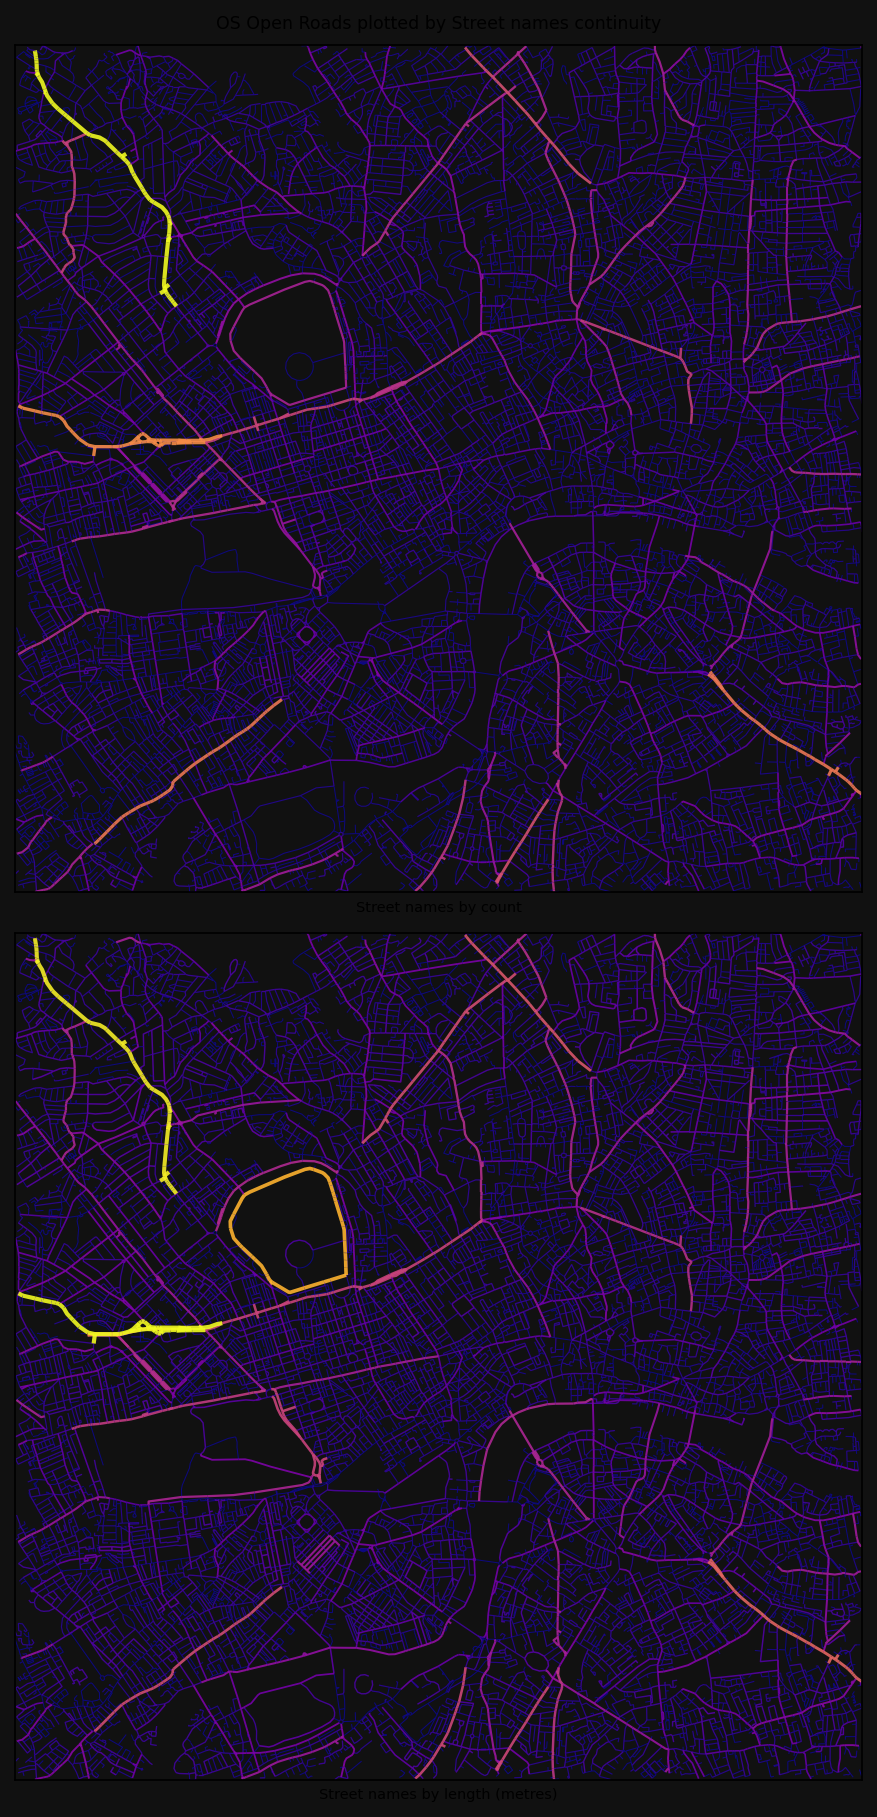

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: routes


30590it [00:00, 117166.71it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30590/30590 [00:07<00:00, 4019.75it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
30590it [00:00, 220774.11it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 30590/30590 [00:09<00:00, 3285.96it/s]


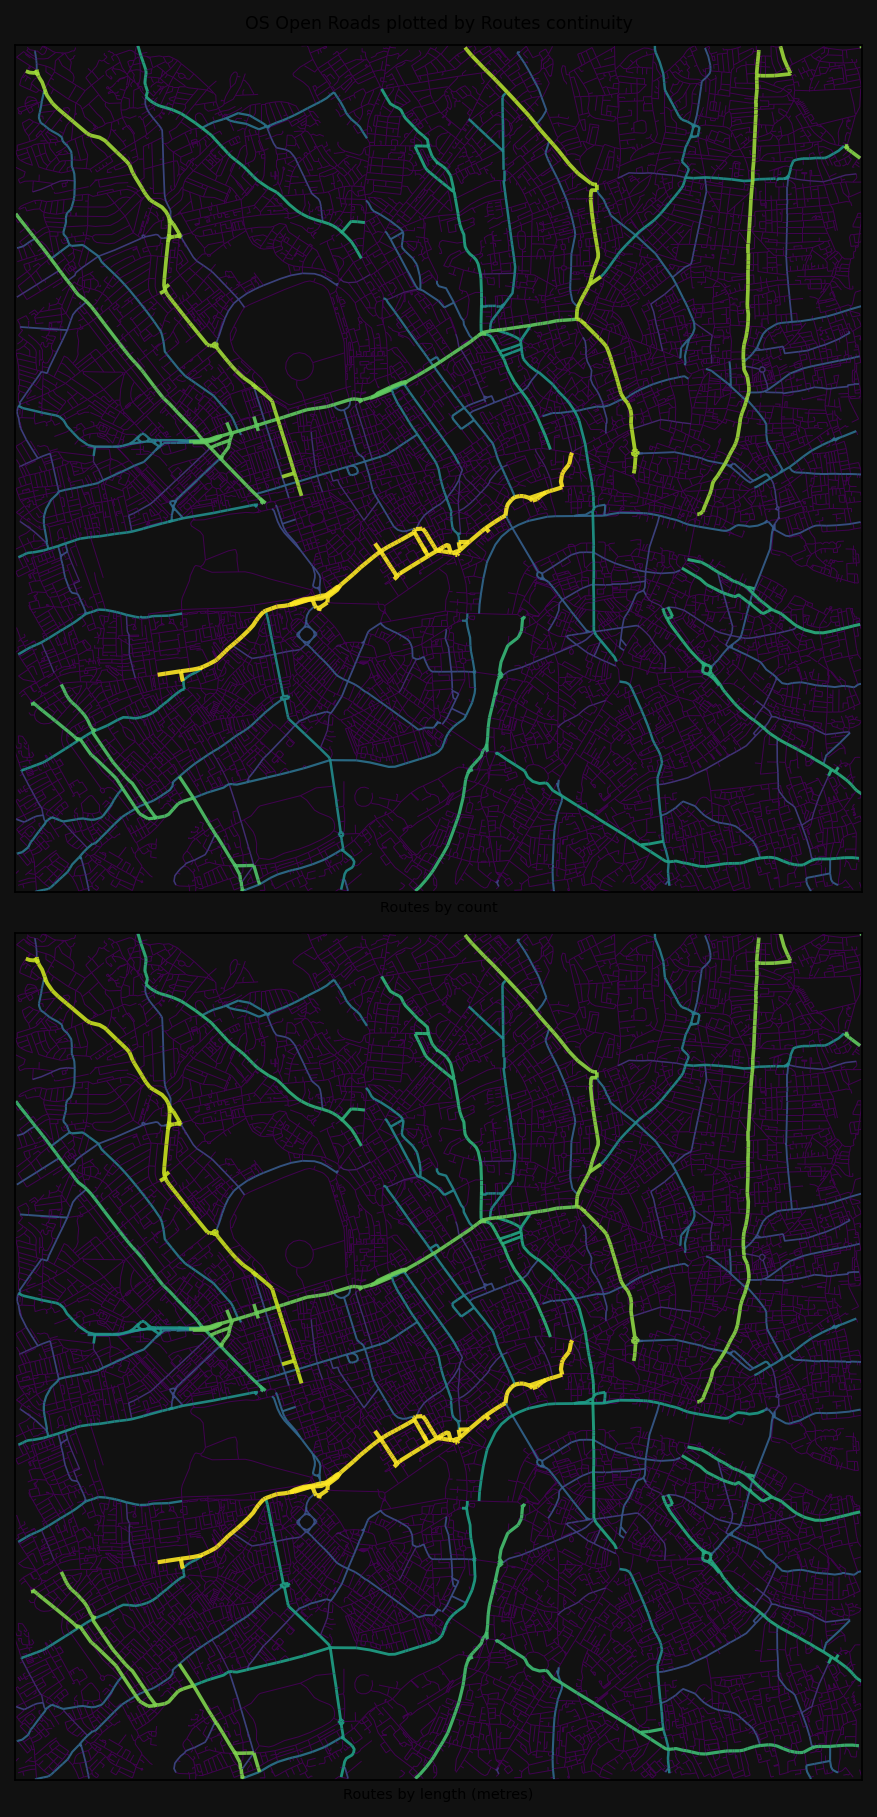

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: highways


30590it [00:00, 63001.35it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
30590it [00:00, 262190.07it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


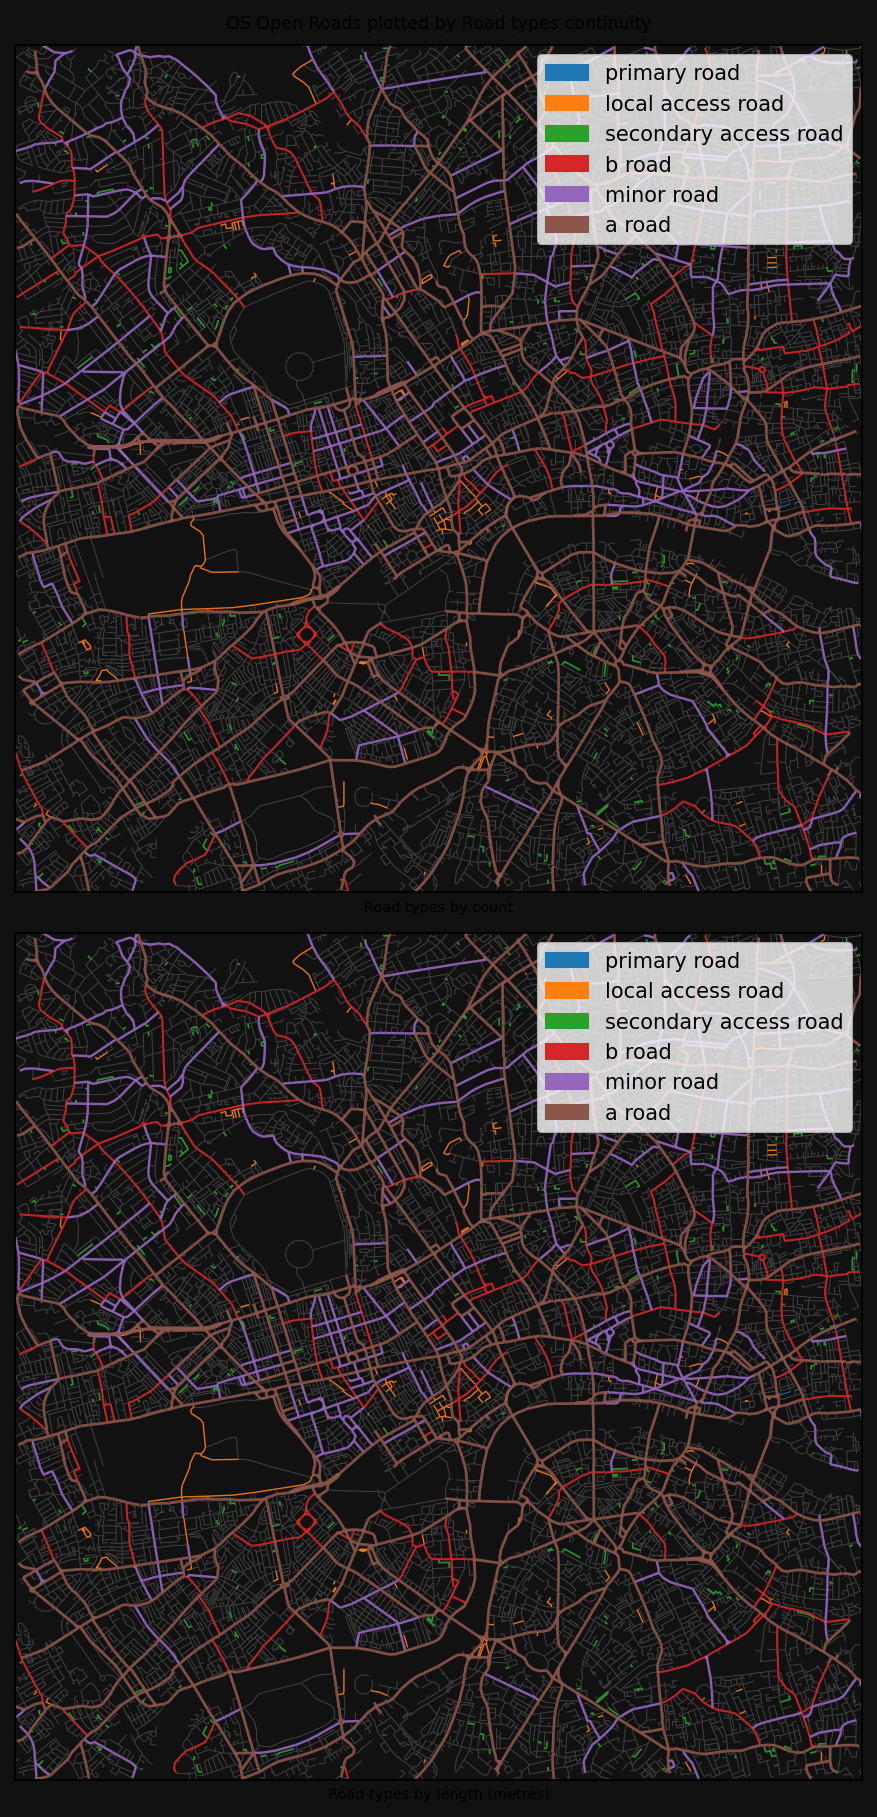

INFO:cityseer.tools.plot:Extracting edge geometries


Plotting results for method: hybrid


30590it [00:00, 117572.77it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
INFO:cityseer.tools.plot:Extracting edge geometries
30590it [00:00, 381931.45it/s]
INFO:cityseer.tools.plot:Generating plot
100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


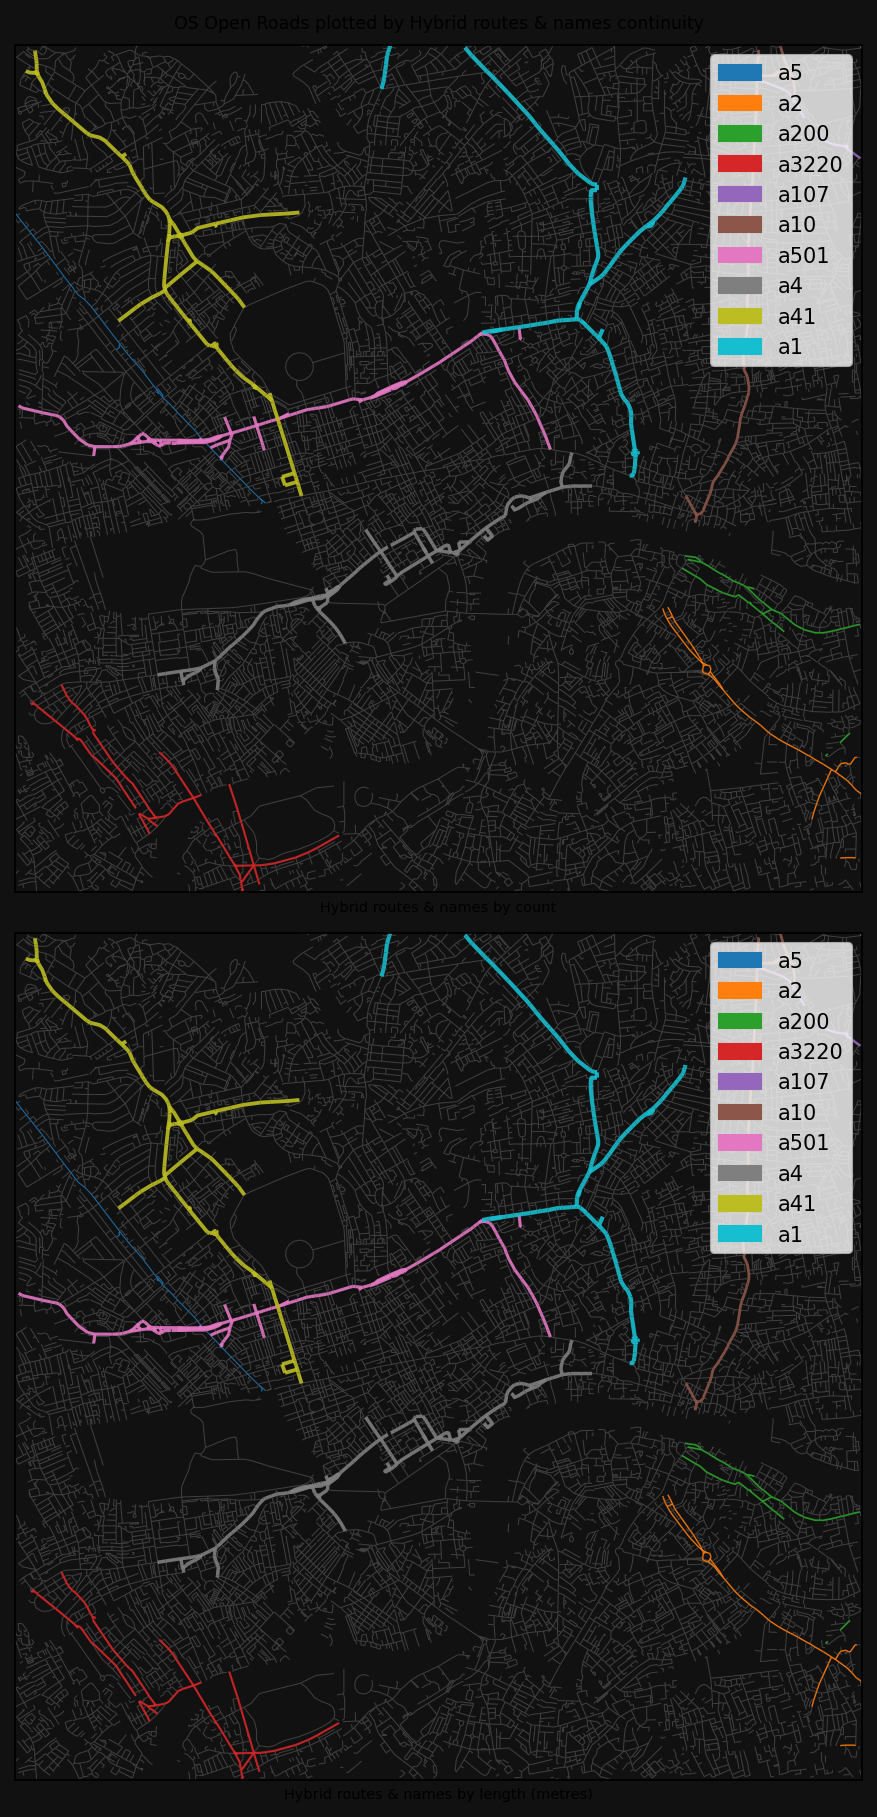

In [5]:
for method, shape_exp, descriptor, cmap, inverse, col_by_categ in zip(
    ["names", "routes", "highways", "hybrid"],  #
    [1, 0.75, 0.5, 1],  #
    ["Street names", "Routes", "Road types", "Hybrid routes & names"],  #
    ["plasma", "viridis", "tab10", "tab10"],  #
    [False, False, True, False],  #
    [False, False, True, True],
):
    print(f"Plotting results for method: {method}")
    # plot
    bg_colour = "#111"
    fig, axes = plt.subplots(
        2, 1, dpi=150, figsize=(8, 12), facecolor=bg_colour, constrained_layout=True
    )
    fig.suptitle(
        f"OS Open Roads plotted by {descriptor} continuity",
        fontsize="small",
        ha="center",
    )
    # by count
    plot.plot_nx_edges(
        axes[0],  # type: ignore
        nx_multigraph=G_cont,
        edge_metrics_key=f"{method}_cont_by_count",
        bbox_extents=plot_bbox,
        cmap_key=cmap,
        lw_min=0.5,
        lw_max=2,
        edge_label_key=f"{method}_cont_by_label",
        colour_by_categorical=col_by_categ,
        shape_exp=shape_exp,
        face_colour=bg_colour,
        invert_plot_order=inverse,
    )
    axes[0].set_xlabel(f"{descriptor} by count", fontsize="x-small")  # type: ignore
    # by length
    plot.plot_nx_edges(
        axes[1],  # type: ignore
        nx_multigraph=G_cont,
        edge_metrics_key=f"{method}_cont_by_length",
        bbox_extents=plot_bbox,
        cmap_key=cmap,
        lw_min=0.5,
        lw_max=2,
        edge_label_key=f"{method}_cont_by_label",
        colour_by_categorical=col_by_categ,
        shape_exp=shape_exp,
        face_colour=bg_colour,
        invert_plot_order=inverse,
    )
    axes[1].set_xlabel(f"{descriptor} by length (metres)", fontsize="x-small")  # type: ignore
    plt.show()